# Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

## Create DataFrames for each region

In [2]:
regions =["south-west", "south-east", "london", "east-of-england","east-midlands", "west-midlands-region","yorkshire-and-the-humber","north-west","north-east"]
df= {}
for region in regions:
    file = f"../data/ukhpi-{region}-from-2000-01-01-to-2024-01-01.csv"
    df[region] = pd.read_csv(file)

In [3]:
df["london"].columns

Index(['Name', 'URI', 'Region GSS code', 'Period', 'Sales volume',
       'Reporting period', 'Average price All property types',
       'Percentage change (yearly) All property types',
       'Percentage change (monthly) All property types',
       'House price index All property types',
       'Sales volume All property types', 'Average price Detached houses',
       'Percentage change (yearly) Detached houses',
       'Percentage change (monthly) Detached houses',
       'House price index Detached houses',
       'Average price Semi-detached houses',
       'Percentage change (yearly) Semi-detached houses',
       'Percentage change (monthly) Semi-detached houses',
       'House price index Semi-detached houses',
       'Average price Terraced houses',
       'Percentage change (yearly) Terraced houses',
       'Percentage change (monthly) Terraced houses',
       'House price index Terraced houses',
       'Average price Flats and maisonettes',
       'Percentage change (yearly) F

# Visualize the average prices in those regions

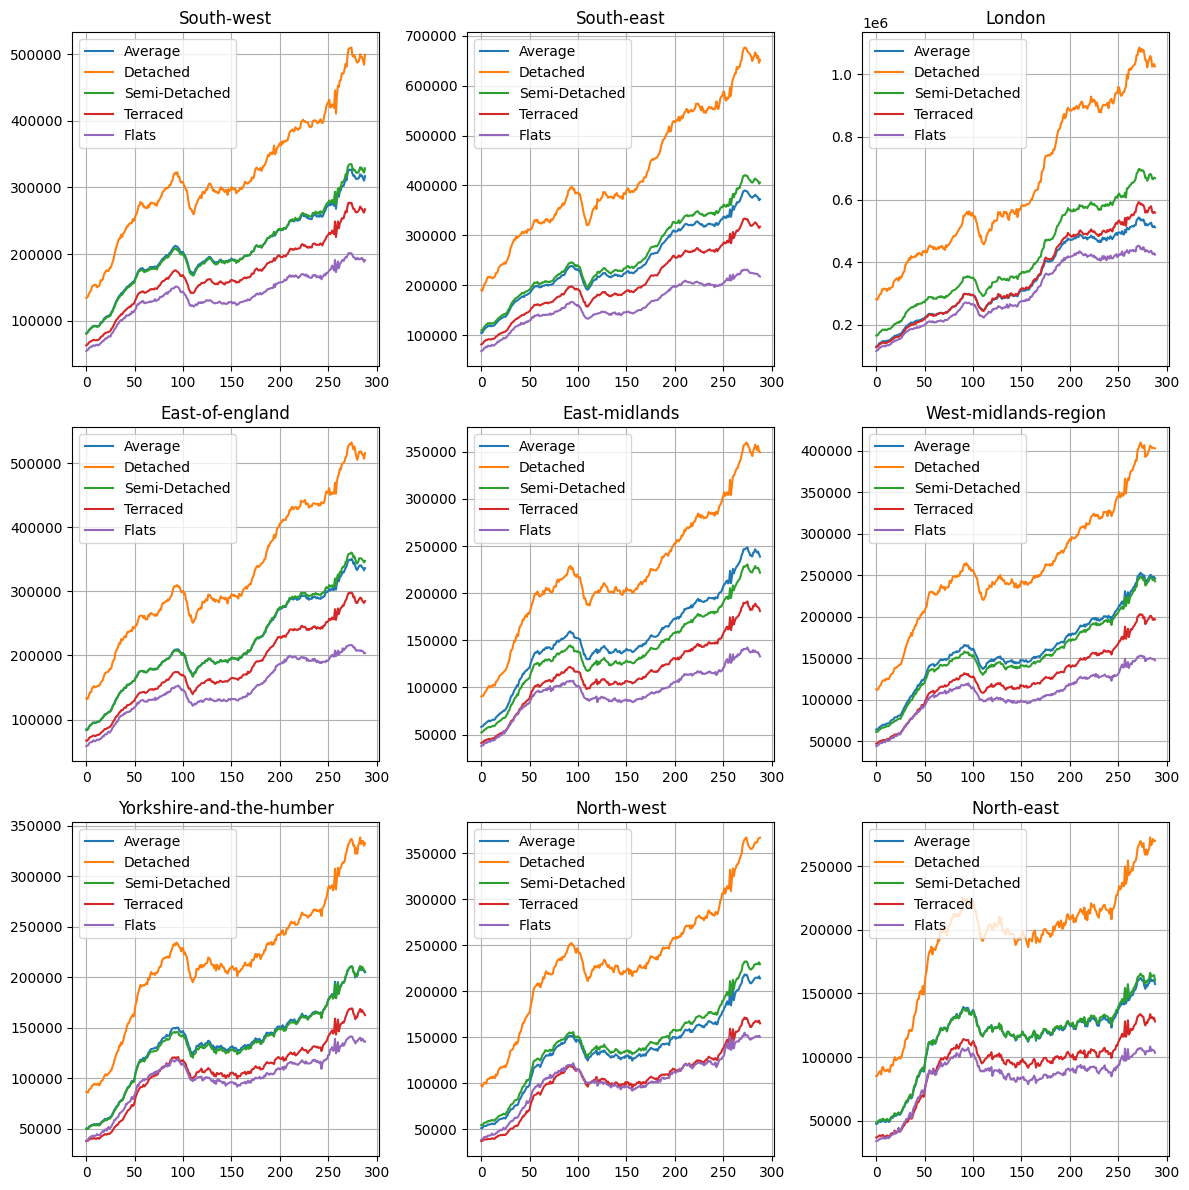

In [4]:
fig, axs = plt.subplots(3, 3, figsize=(12, 12))
for idx, region in enumerate(regions):
    row = idx // 3
    col = idx % 3
    axs[row, col].set_title(f"{region.capitalize()}")
    axs[row, col].plot(df[region]["Average price All property types"], label="Average")
    axs[row, col].plot(df[region]["Average price Detached houses"], label="Detached")
    axs[row, col].plot(df[region]["Average price Semi-detached houses"], label="Semi-Detached")
    axs[row, col].plot(df[region]["Average price Terraced houses"], label="Terraced")
    axs[row, col].plot(df[region]["Average price Flats and maisonettes"], label="Flats")
    axs[row, col].legend()
    axs[row, col].grid()
plt.tight_layout()
plt.show()

The data shows a obvious uptrend but the average price in some areas is only lower than detached houses and in other more expensive areas the average is below both semi-detached and terraced houses. This indicates that London property sales are heavily weighted towards flats and maisonettes.

The most common mistake of LSTM models is using the prices as the target for the model. Instead the model should be trying to predict the change in price.

In [5]:
#Models features
df_london_features = df["london"][['House price index All property types',
                                  'Sales volume All property types',
                                  "Average price All property types",
                                  'Sales volume New build']]

#Models Target
df_london_target = df["london"]["Percentage change (monthly) All property types"]

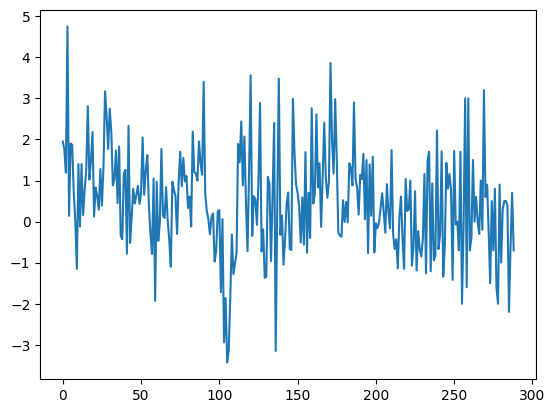

In [6]:
plt.plot(df_london_target)
plt.show()

## Training an LSTM model to predict prices

The goal for the model I'm about to train is to predict the future average price data for London houses. This will be approached by setting the target of the model as the monthly percentage price change to then calculate the new average prices from the predicted percentage changes.

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.preprocessing import StandardScaler
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [9]:
X = df_london_features.values
y = df_london_target.values
y = y.reshape(-1, 1)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.15, shuffle=False)


In [10]:
# Scaling
scaler_x = StandardScaler()
scaler_y = StandardScaler()

X_train = scaler_x.fit_transform(X_train)
X_test = scaler_x.transform(X_test)
y_train = scaler_y.fit_transform(y_train)
y_test = scaler_y.transform(y_test)

# Convert to PyTorch tensors
#Train
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)

#Test
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)

In [11]:
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = TimeSeriesDataset(X_train_tensor, y_train_tensor)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [12]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h_0 = torch.zeros(num_layers, x.size(0), hidden_size).to(x.device)
        c_0 = torch.zeros(num_layers, x.size(0), hidden_size).to(x.device)
        out, (hn, cn) = self.lstm(x, (h_0, c_0))
        out = self.fc(out[:, -1, :])
        return out

input_size = df_london_features.shape[1]
hidden_size = 50
num_layers = 1
output_size = 1

model = LSTMModel(input_size, hidden_size, num_layers, output_size).to(device)

In [13]:
# Loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    for inputs, targets in train_dataloader:
        # Forward pass
        outputs = model(inputs.unsqueeze(1))
        loss = criterion(outputs, targets)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


Epoch [10/100], Loss: 0.9586
Epoch [20/100], Loss: 1.4700
Epoch [30/100], Loss: 1.4700
Epoch [40/100], Loss: 0.9070
Epoch [50/100], Loss: 1.0114
Epoch [60/100], Loss: 0.8144
Epoch [70/100], Loss: 0.5401
Epoch [80/100], Loss: 0.3470
Epoch [90/100], Loss: 1.7369
Epoch [100/100], Loss: 1.0143


Mean Squared Error: 1.5417


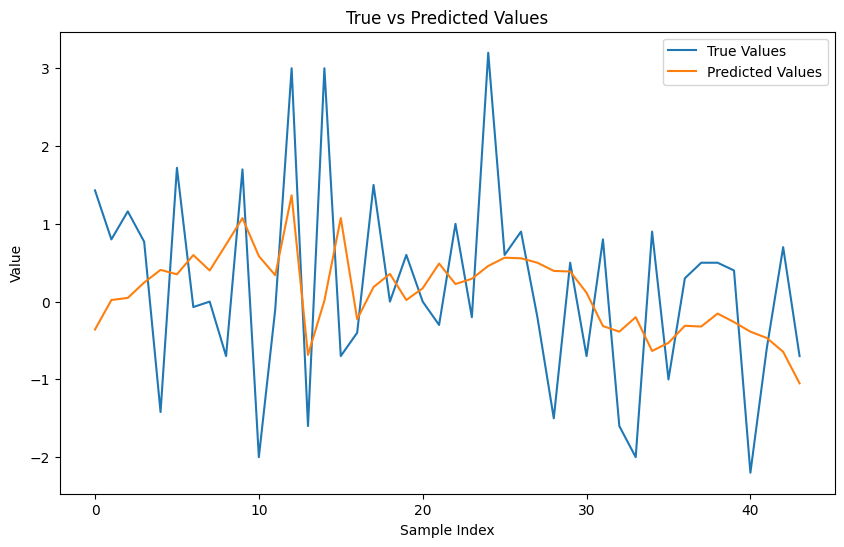

In [14]:
# Evaluation
model.eval()

with torch.no_grad():
    y_pred_tensor = model(X_test_tensor.unsqueeze(1))

y_pred = y_pred_tensor.cpu().numpy()
y_pred_original = scaler_y.inverse_transform(y_pred)
y_test_original = scaler_y.inverse_transform(y_test)

mse = mean_squared_error(y_test_original, y_pred_original)
print(f'Mean Squared Error: {mse:.4f}')

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(y_test_original, label='True Values')
plt.plot(y_pred_original, label='Predicted Values')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.title('True vs Predicted Values')
plt.legend()
plt.show()


Here we can see the model can predict the general movement of the price changes but struggles with the magnitude of the changes.

## Using the predicted price changes to calculate the new average house prices

In [15]:
last_values = X_test_tensor[-1:].unsqueeze(1)

In [16]:
prices = model(X_test_tensor.unsqueeze(1))
prices_numpy = prices.detach().cpu().numpy()
price_changes = scaler_y.inverse_transform(prices_numpy)
#price_changes

In [17]:
new_prices = []
scaler_x.inverse_transform(X_test)
previous_price = X_test[1, 2]
print(f"Previous price: {previous_price}")
for i in range(len(price_changes)):
    p = price_changes[i]
    new_prices.append(previous_price * (1 + p / 100))
    previous_price = new_prices[-1]

Previous price: 1.6004350019742781


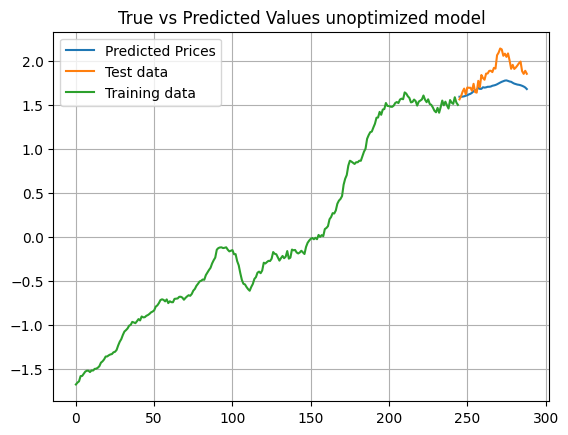

In [18]:
#Align all of the indices
train_indices = np.arange(len(X_train[:,2]))
test_indices = np.arange(len(X_train[:,2]), len(X_train[:,2]) + len(X_test[:,2]))
pred_indices = np.arange(len(X_train[:,2]), len(X_train[:,2]) + len(new_prices))

# Plotting
plt.plot(pred_indices, new_prices, label="Predicted Prices")
plt.plot(test_indices, X_test[:,2], label="Test data")
plt.plot(train_indices, X_train[:,2], label="Training data")

plt.title('True vs Predicted Values unoptimized model')

plt.legend()
plt.grid()
plt.show()

The predicted data within the graph trends in the correct direction but not to the same magnitude. This difference between the real and preddicted values is only widened the further into the prediction period we go as the model is making predictions on predictions.

# Saving the model

Uncomment the code below to save the model.

In [19]:
#torch.save(model, 'no_optimization_model.pth')
#print("Model saved")

# Moving on to optimization for the model

In [20]:
import optuna

In [21]:
class TimeSeriesDataset(Dataset):
    def __init__(self, data, targets):
        self.data = data
        self.targets = targets
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        x = self.data[index]
        y = self.targets[index]
        # Ensure x is 2D (seq_len, input_size)
        x = x.reshape(-1, self.data.shape[1])
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

In [22]:
# Sample Data
X = df_london_features.values
y = df_london_target.values
y = y.reshape(-1, 1)

# Split into training, validation and test sets
X_train, X, y_train, y = train_test_split(X, y, test_size=0.3, shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X, y, test_size=0.5, shuffle=False)

# Scaling
scaler_x = StandardScaler()
scaler_y = StandardScaler()

X_train = scaler_x.fit_transform(X_train)
X_val = scaler_x.transform(X_val)
X_test = scaler_x.transform(X_test)

y_train = scaler_y.fit_transform(y_train)
y_val = scaler_y.transform(y_val)
y_test = scaler_y.transform(y_test)


# Create datasets
train_dataset = TimeSeriesDataset(X_train, y_train)
val_dataset = TimeSeriesDataset(X_val, y_val)
test_dataset = TimeSeriesDataset(X_test, y_val)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

#Train
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)

#Test
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)

In [23]:
class MultiInputLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout=0.2):
        super(MultiInputLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        batch_size = x.size(0)
        h_0 = torch.zeros(self.lstm.num_layers, batch_size, self.lstm.hidden_size).to(x.device)
        c_0 = torch.zeros(self.lstm.num_layers, batch_size, self.lstm.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h_0, c_0))
        out = self.fc(out[:, -1, :])
        return out

In [24]:
def objective(trial):
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-1, log=True)
    num_layers = trial.suggest_int('num_layers', 1, 4)
    hidden_size = trial.suggest_int('hidden_size', 16, 128)
    dropout = trial.suggest_float('dropout', 0, 0.5)
    
    model = MultiInputLSTM(
        input_size=X_train.shape[1],
        hidden_size=hidden_size,
        num_layers=num_layers,
        output_size=1,
        dropout=dropout
    ).to(device)
    
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    num_epochs = 10
    for epoch in range(num_epochs):
        model.train()
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
    
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item()
    
    val_loss /= len(val_loader)
    
    return val_loss

In [25]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

best_params = study.best_params
print(f'Best hyperparameters: {best_params}')

[I 2024-06-02 11:10:55,958] A new study created in memory with name: no-name-5b82c952-9a73-41f1-a6f1-4182fa8bc6b5
[I 2024-06-02 11:10:56,177] Trial 0 finished with value: 0.9583147764205933 and parameters: {'learning_rate': 0.0005796284128984095, 'num_layers': 2, 'hidden_size': 31, 'dropout': 0.45538371536759703}. Best is trial 0 with value: 0.9583147764205933.
C:\Users\Max\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.33855923520037845 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
[I 2024-06-02 11:10:56,370] Trial 1 finished with value: 0.8629581332206726 and parameters: {'learning_rate': 3.5388726754641175e-05, 'num_layers': 1, 'hidden_size': 72, 'dropout': 0.33855923520037845}. Best is trial 1 with value: 0.8629581332206726.
C:\Users\Max\AppData\Local\Programs\

[I 2024-06-02 11:11:02,587] Trial 27 finished with value: 0.8683130741119385 and parameters: {'learning_rate': 0.00045792549992614446, 'num_layers': 2, 'hidden_size': 87, 'dropout': 0.4207000891390021}. Best is trial 26 with value: 0.7749614417552948.
[I 2024-06-02 11:11:02,826] Trial 28 finished with value: 0.7962620556354523 and parameters: {'learning_rate': 0.0013227575530344324, 'num_layers': 2, 'hidden_size': 99, 'dropout': 0.3383926864601726}. Best is trial 26 with value: 0.7749614417552948.
[I 2024-06-02 11:11:03,058] Trial 29 finished with value: 1.3128191232681274 and parameters: {'learning_rate': 0.09657276496135357, 'num_layers': 2, 'hidden_size': 70, 'dropout': 0.47652226917660456}. Best is trial 26 with value: 0.7749614417552948.
[I 2024-06-02 11:11:03,301] Trial 30 finished with value: 0.8140678107738495 and parameters: {'learning_rate': 0.0007766053232941765, 'num_layers': 2, 'hidden_size': 80, 'dropout': 0.4441121973705542}. Best is trial 26 with value: 0.77496144175529

[I 2024-06-02 11:11:09,521] Trial 55 finished with value: 1.1875472962856293 and parameters: {'learning_rate': 0.014336524490477493, 'num_layers': 3, 'hidden_size': 53, 'dropout': 0.004172231652913305}. Best is trial 47 with value: 0.7081907689571381.
[I 2024-06-02 11:11:09,765] Trial 56 finished with value: 0.974665641784668 and parameters: {'learning_rate': 0.00030045465552438984, 'num_layers': 3, 'hidden_size': 35, 'dropout': 0.15446481071429616}. Best is trial 47 with value: 0.7081907689571381.
[I 2024-06-02 11:11:10,029] Trial 57 finished with value: 0.8998756408691406 and parameters: {'learning_rate': 0.0005442455891191823, 'num_layers': 4, 'hidden_size': 68, 'dropout': 0.09440885601492122}. Best is trial 47 with value: 0.7081907689571381.
[I 2024-06-02 11:11:10,294] Trial 58 finished with value: 0.9449278116226196 and parameters: {'learning_rate': 0.0037871023813514926, 'num_layers': 4, 'hidden_size': 63, 'dropout': 0.12295304320434644}. Best is trial 47 with value: 0.7081907689

C:\Users\Max\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4991143641061929 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
[I 2024-06-02 11:11:17,331] Trial 87 finished with value: 0.7718622386455536 and parameters: {'learning_rate': 0.0012759284936684934, 'num_layers': 1, 'hidden_size': 72, 'dropout': 0.4991143641061929}. Best is trial 47 with value: 0.7081907689571381.
[I 2024-06-02 11:11:17,570] Trial 88 finished with value: 0.824691891670227 and parameters: {'learning_rate': 0.0019316361990842502, 'num_layers': 2, 'hidden_size': 65, 'dropout': 0.48252475674341433}. Best is trial 47 with value: 0.7081907689571381.
[I 2024-06-02 11:11:17,808] Trial 89 finished with value: 0.7991716265678406 and parameters: {'learning_rate': 0.0007122452477580304, 'num_layers': 2,

Best hyperparameters: {'learning_rate': 0.0009401150989471373, 'num_layers': 3, 'hidden_size': 75, 'dropout': 0.1504532090107696}


In [26]:
#Define a model with the best parameters
optimized_model = MultiInputLSTM(
    input_size=4,
    hidden_size=best_params['hidden_size'],
    num_layers=best_params['num_layers'],
    output_size=1,
    dropout=best_params['dropout']
).to(device)

In [27]:
# Loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=best_params['learning_rate']) #Set the learning rate to the best too 

# Training loop
num_epochs = 100

for epoch in range(num_epochs):
    for inputs, targets in train_loader:
        optimized_model.train()
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            
            optimizer.zero_grad()
            outputs = optimized_model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


Epoch [10/100], Loss: 2.0244
Epoch [20/100], Loss: 1.6383
Epoch [30/100], Loss: 1.0780
Epoch [40/100], Loss: 1.2116
Epoch [50/100], Loss: 1.1321
Epoch [60/100], Loss: 0.9130
Epoch [70/100], Loss: 1.2039
Epoch [80/100], Loss: 1.5058
Epoch [90/100], Loss: 0.9124
Epoch [100/100], Loss: 0.3873


Mean Squared Error: 1.8888


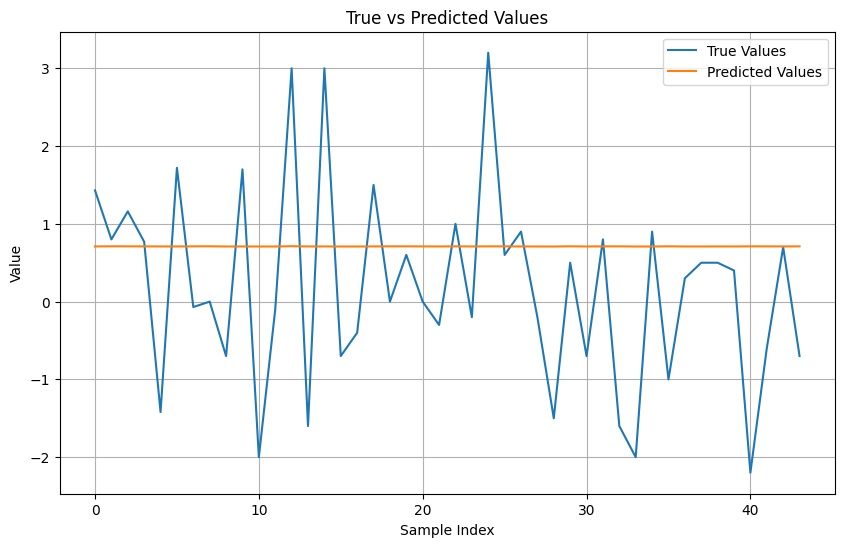

In [28]:
# Evaluation
model.eval()

with torch.no_grad():
    y_pred_tensor = optimized_model(X_test_tensor.unsqueeze(1))

y_pred = y_pred_tensor.cpu().numpy()
y_pred_original = scaler_y.inverse_transform(y_pred)
y_test_original = scaler_y.inverse_transform(y_test)

mse = mean_squared_error(y_test_original, y_pred_original)
print(f'Mean Squared Error: {mse:.4f}')

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(y_test_original, label='True Values')
plt.plot(y_pred_original, label='Predicted Values')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.title('True vs Predicted Values')
plt.legend()
plt.grid()
plt.show()


In [29]:
last_values = X_test_tensor[-1:].unsqueeze(1)

In [30]:
prices = model(X_test_tensor.unsqueeze(1))
prices_numpy = prices.detach().cpu().numpy()
price_changes = scaler_y.inverse_transform(prices_numpy)
#price_changes

In [31]:
new_prices = []
scaler_x.inverse_transform(X_test)
previous_price = X_test[1, 2]
print(f"Previous price: {previous_price}")
for i in range(len(price_changes)):
    p = price_changes[i]
    new_prices.append(previous_price * (1 + p / 100))
    previous_price = new_prices[-1]

Previous price: 2.4692508798055393


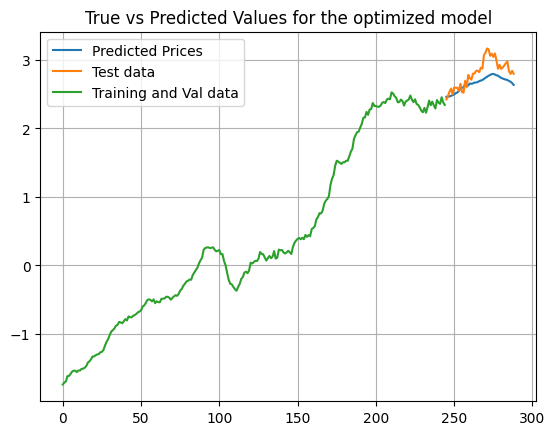

In [32]:
# Align all of the indices
train_val_indices = np.arange(len(X_train[:, 2]) + len(X_val[:, 2]))
test_indices = np.arange(len(X_train[:, 2]) + len(X_val[:, 2]), len(X_train[:, 2]) + len(X_val[:, 2]) + len(X_test[:, 2]))
pred_indices = np.arange(len(X_train[:, 2]) + len(X_val[:, 2]), len(X_train[:, 2]) + len(X_val[:, 2]) + len(new_prices))

# Combine training and validation data
train_val_data = np.concatenate((X_train[:, 2], X_val[:, 2]))

# Plotting
plt.plot(pred_indices, new_prices, label="Predicted Prices")
plt.plot(test_indices, X_test[:, 2], label="Test data")
plt.plot(train_val_indices, train_val_data, label="Training and Val data")
plt.title('True vs Predicted Values for the optimized model')

plt.legend()
plt.grid()
plt.show()


Here we can see the predicted values much more closly follow the real data when compared to the unoptimized model

# Save the model

Uncomment the code below to save the model

In [33]:
#torch.save(model, 'optimized_model.pth')
#print("Model saved")